In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall, Precision
import tensorflow as tf
from tensorflow.image import flip_left_right, rot90

In [2]:
# === Config ===
# path_light = '/Volumes/DiskMorgane/light_data'
# path ='../data/pictures_raw/train'
path ='/Volumes/DiskMorgane/bach_32/bach_1'
path_train_csv = '../data/csv_raw/train_labels.csv'

# === Cargar y procesar DataFrame ===
df = pd.read_csv(path_train_csv).copy()
df['motor_place'] = np.where(df['Motor_axis_0'] < 0, -1, (df['Motor_axis_0'] / df['Array_shape_axis_0'] * 32).astype(int))
df = df.groupby('tomo_id').first().reset_index()
#######################
# tomo_ids = ['tomo_00e047', 'tomo_0fe63f', 'tomo_1e9980']
# df = df[df['tomo_id'].isin(tomo_ids)]
# ##################
df

,tomo_id,Unnamed: 0,row_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors,motor_place
0,tomo_003acc,283,0,-1.0,-1.0,-1.0,500,1912,1847,6.5,0,-1
1,tomo_00e047,338,1,169.0,546.0,603.0,300,959,928,15.6,1,18
2,tomo_00e463,709,2,235.0,403.0,137.0,500,924,956,19.7,6,15
3,tomo_01a877,404,8,147.0,638.0,286.0,300,960,928,13.1,1,15
4,tomo_02862f,339,9,101.0,351.0,120.0,300,959,928,15.6,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...
643,tomo_fe050c,402,732,138.0,134.0,542.0,300,959,928,15.6,1,14
644,tomo_fe85f6,155,733,-1.0,-1.0,-1.0,800,928,960,13.1,0,-1
645,tomo_fea6e8,264,734,-1.0,-1.0,-1.0,300,960,928,16.8,0,-1
646,tomo_ff505c,403,735,111.0,816.0,678.0,300,959,928,15.6,1,11


In [3]:


def load_motor_images(df, path_base, resize_shape=(512, 512), total_slices=32, num_random_negatives=5):
    """
    Load images from tomographs based on motor positions.

    Parameters:
    - df: pandas DataFrame containing the metadata
    - path_base: base path where all tomograph folders are located (e.g. '../data/pictures_raw/train')
    - resize_shape: tuple with the resize shape for each image (default: (512, 512))
    - total_slices: number of slices per tomograph (default: 32)
    - num_random_negatives: number of random negative slices to add per sample

    Returns:
    - X: numpy array of images (each image resized)
    - Y: list of labels (1 for motor location, 0 for negatives)
    """
    X = []
    Y = []

    for idx, row in df.iterrows():
        motor_slice = row['motor_place']
        tomo_id = row['tomo_id']

        if motor_slice > 0:
            # --- Positive sample ---
            # main_img_path = os.path.join(path_base, tomo_id, f"slice_{motor_slice:04d}.jpg")
            main_img_path = os.path.join(path_base, tomo_id, f"batch_{motor_slice:02d}.png")
            if os.path.exists(main_img_path):
                img = cv2.imread(main_img_path, cv2.IMREAD_GRAYSCALE)
                img_resized = cv2.resize(img, resize_shape)
                X.append(img_resized)
                Y.append(1)

            # --- Negative samples: motor_slice ±2 ---
            for offset in [-2, +2]:
                neg_slice = motor_slice + offset
                if 0 <= neg_slice < total_slices:
                    # neg_path = os.path.join(path_base, tomo_id, f"slice_{neg_slice:04d}.jpg")
                    neg_path = os.path.join(path_base, tomo_id, f"batch_{neg_slice:02d}.png")
                    if os.path.exists(neg_path):
                        img = cv2.imread(neg_path, cv2.IMREAD_GRAYSCALE)
                        img_resized = cv2.resize(img, resize_shape)
                        X.append(img_resized)
                        Y.append(0)

            # --- Random negative samples ---
            possible_slices = list(set(range(total_slices)) - {motor_slice})
            rand_slices = random.sample(possible_slices, min(num_random_negatives, len(possible_slices)))
            for rand_slice in rand_slices:
                # rand_path = os.path.join(path_base, tomo_id, f"slice_{rand_slice:04d}.jpg")
                rand_path = os.path.join(path_base, tomo_id, f"batch_{rand_slice:02d}.png")
                if os.path.exists(rand_path):
                    img = cv2.imread(rand_path, cv2.IMREAD_GRAYSCALE)
                    img_resized = cv2.resize(img, resize_shape)
                    X.append(img_resized)
                    Y.append(0)

    X = np.array(X)
    Y = np.array(Y)

    return X, Y


X, y = load_motor_images(df, path_base=path)

X.shape, y.shape


((2824, 512, 512), (2824,))

In [4]:
print(y[100])
print(X[100])

0
[[123 128 131 ... 115 111 106]
 [127 122 127 ... 111 107 102]
 [108 121 131 ... 108 103  98]
 ...
 [108 111 115 ... 153 134 121]
 [115 117 121 ... 125 125 115]
 [121 123 127 ... 118 111 108]]


In [5]:


def augment_positives_to_balance(X, y):
    """
    Augments positive samples (y==1) to balance the number of negative (y==0) samples.

    Augmentations:
    - Add 5% Gaussian noise
    - Rotate 90, 180, 270 degrees
    - Zoom in by 10%

    Parameters:
    - X: numpy array of grayscale images (H, W)
    - y: numpy array of labels (0 or 1)

    Returns:
    - X_balanced: augmented + original images
    - y_balanced: corresponding labels
    """
    X_aug = []
    y_aug = []

    positives = [img for img, label in zip(X, y) if label == 1]
    num_positives = len(positives)
    num_negatives = np.sum(y == 0)

    # How many augmentations we need
    num_needed = num_negatives - num_positives
    if num_needed <= 0:
        return X, y  # Already balanced or over-sampled

    def add_noise(img):
        noise = np.random.normal(0, 0.05 * 255, img.shape).astype(np.float32)
        noisy = np.clip(img.astype(np.float32) + noise, 0, 255).astype(np.uint8)
        return noisy

    def rotate_image(img, angle):
        if angle == 0:
            return img
        return cv2.rotate(img, {
            90: cv2.ROTATE_90_CLOCKWISE,
            180: cv2.ROTATE_180,
            270: cv2.ROTATE_90_COUNTERCLOCKWISE
        }[angle])

    def zoom_image(img, zoom_percent=0.1):
        h, w = img.shape
        zoom_h = int(h * zoom_percent)
        zoom_w = int(w * zoom_percent)
        cropped = img[zoom_h:h-zoom_h, zoom_w:w-zoom_w]
        return cv2.resize(cropped, (w, h))

    transforms = [add_noise,
                  lambda img: rotate_image(img, 90),
                  lambda img: rotate_image(img, 180),
                  lambda img: rotate_image(img, 270),
                  zoom_image]

    while len(y_aug) < num_needed:
        img = random.choice(positives)
        transform = random.choice(transforms)
        img_aug = transform(img)
        X_aug.append(img_aug)
        y_aug.append(1)

    X_balanced = np.concatenate([X, np.array(X_aug)], axis=0)
    y_balanced = np.concatenate([y, np.array(y_aug)], axis=0)

    return X_balanced, y_balanced


X_balaced,y_balanced =augment_positives_to_balance (X , y)

In [6]:
X_balaced.shape, y_balanced.shape

((4928, 512, 512), (4928,))

In [7]:
def reshape_for_cnn(X):
    """
    Reshape grayscale image data to (num_photos, 512, 512, 1)

    Parameters:
    - X: numpy array of shape (num_photos, H, W)

    Returns:
    - X_reshaped: numpy array of shape (num_photos, 512, 512, 1)
    """
    if X.ndim != 3:
        raise ValueError("Input X must be of shape (num_photos, height, width)")

    X_reshaped = X[..., np.newaxis]  # Add channel dimension
    return X_reshaped

X_balaced= reshape_for_cnn(X_balaced)
X_balaced.shape

(4928, 512, 512, 1)

In [8]:
# === División del dataset ===
X_train, X_test, y_train, y_test = train_test_split(X_balaced, y_balanced, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:

# === Modelo con DenseNet ===
def init_model_densenet(X):
    original_input_shape = X.shape[1:]
    base_input_shape = original_input_shape[:-1] + (3,) if original_input_shape[-1] == 1 else original_input_shape

    #  --- Not used the last layer of training in
    base_model = DenseNet121(include_top=False,
                             weights='imagenet',
                             input_shape=base_input_shape)
    base_model.trainable = False

    #  ---add BatchNormalization??
    inputs = Input(shape=original_input_shape)
    x = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(inputs) if original_input_shape[-1] == 1 else inputs
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy', Recall(), Precision()]
    )
    return model

# === Entrenamiento ===
def model_train(model, X_train, y_train, batch_size=16, epochs=20):
    es = EarlyStopping(patience=3, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[es],
        verbose=1
    )
    return history

# Inicializa y entrena
model = init_model_densenet(X_train)
history = model_train(model, X_train, y_train)

Epoch 1/20


2025-06-09 21:40:08.362982: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


222/222 [==============================] - 853s 4s/step - loss: 1.6508 - accuracy: 0.5330 - recall: 0.5309 - precision: 0.5396 - val_loss: 1.0115 - val_accuracy: 0.5276 - val_recall: 0.9977 - val_precision: 0.5140
Epoch 2/20
222/222 [==============================] - 955s 4s/step - loss: 1.1979 - accuracy: 0.5696 - recall: 0.5865 - precision: 0.5734 - val_loss: 0.6674 - val_accuracy: 0.6077 - val_recall: 0.9323 - val_precision: 0.5650
Epoch 3/20
222/222 [==============================] - 817s 4s/step - loss: 1.0087 - accuracy: 0.5893 - recall: 0.5999 - precision: 0.5936 - val_loss: 0.5911 - val_accuracy: 0.6483 - val_recall: 0.9503 - val_precision: 0.5921
Epoch 4/20
222/222 [==============================] - 868s 4s/step - loss: 0.8583 - accuracy: 0.6065 - recall: 0.6183 - precision: 0.6101 - val_loss: 0.5489 - val_accuracy: 0.7452 - val_recall: 0.7269 - val_precision: 0.7541
Epoch 5/20
222/222 [==============================] - 886s 4s/step - loss: 0.7781 - accuracy: 0.6291 - recall: 

In [10]:
history.history

{'loss': [1.6507729291915894,
  1.1978702545166016,
  1.008726954460144,
  0.8583254814147949,
  0.7780968546867371,
  0.7225701212882996,
  0.6988931894302368],
 'accuracy': [0.5329763293266296,
  0.5696166753768921,
  0.5893461108207703,
  0.6065388917922974,
  0.6290867924690247,
  0.6443066596984863,
  0.6352874636650085],
 'recall': [0.5308848023414612,
  0.5865331292152405,
  0.5998886823654175,
  0.6182526350021362,
  0.641624927520752,
  0.6611018180847168,
  0.642181396484375],
 'precision': [0.5395927429199219,
  0.5734493732452393,
  0.5936123132705688,
  0.6101043224334717,
  0.6317808032035828,
  0.6453014612197876,
  0.6393351554870605],
 'val_loss': [1.011452078819275,
  0.6673532128334045,
  0.5910895466804504,
  0.548930287361145,
  0.5537065267562866,
  0.5615665912628174,
  0.5686076879501343],
 'val_accuracy': [0.5276212096214294,
  0.6076663136482239,
  0.648252546787262,
  0.7452085614204407,
  0.7564825415611267,
  0.7531003355979919,
  0.7531003355979919],
 'val

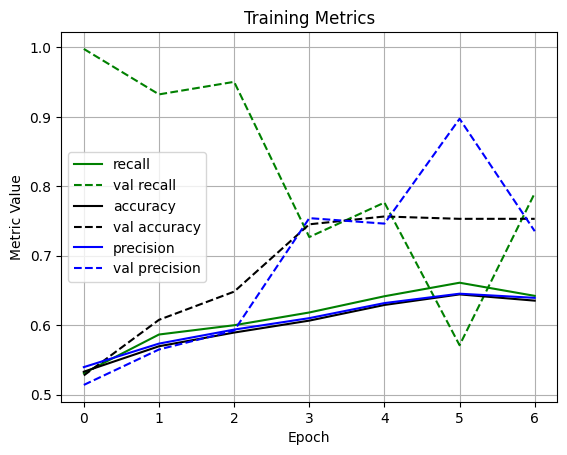

In [11]:

import matplotlib.pyplot as plt
def plot_training_metrics(history):
    """
   plot the metrics, even if there is not one of them into 'history'
    """
    history_dict = history.history
    plotted = False

    def safe_plot(metric_name, color, linestyle='-'):
        nonlocal plotted
        if metric_name in history_dict:
            label = metric_name.replace('_', ' ')
            plt.plot(history_dict[metric_name], c=color, linestyle=linestyle, label=label)
            plotted = True

    # fbeta
    safe_plot('fbeta_score', 'r')
    safe_plot('val_fbeta_score', 'r', '--')

    # recall
    safe_plot('recall', 'g')
    safe_plot('val_recall', 'g', '--')
    safe_plot('recall_1', 'g')  # alternativa por si usa nombre automático
    safe_plot('val_recall_1', 'g', '--')

    # accuracy
    safe_plot('accuracy', 'black')
    safe_plot('val_accuracy', 'black', '--')

    # precision
    safe_plot('precision', 'blue')
    safe_plot('val_precision', 'blue', '--')

    if plotted:
        plt.title("Training Metrics")
        plt.xlabel("Epoch")
        plt.ylabel("Metric Value")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("⚠️ No se encontró ninguna métrica conocida para graficar.")


plot_training_metrics(history)

In [12]:
model.evaluate(X_test,y_test)

16/16 [==============================] - 111s 7s/step - loss: 0.5682 - accuracy: 0.7383 - recall: 0.7009 - precision: 0.7169


[0.5681505799293518,
 0.7383367419242859,
 0.7008928656578064,
 0.7168949842453003]

In [13]:
y_pred= model.predict(X_test )
y_pred

16/16 [==============================] - 109s 7s/step


array([[0.4088704 ],
       [0.82881266],
       [0.01982644],
       [0.39677477],
       [0.2820765 ],
       [0.36318177],
       [0.499836  ],
       [0.36068946],
       [0.47145274],
       [0.36043715],
       [0.39217058],
       [0.23865254],
       [0.64493704],
       [0.30216366],
       [0.3274616 ],
       [0.35236958],
       [0.21927403],
       [0.37437764],
       [0.8669649 ],
       [0.2795898 ],
       [0.47945604],
       [0.5389357 ],
       [0.6276408 ],
       [0.48575324],
       [0.61651736],
       [0.2865508 ],
       [0.8525673 ],
       [0.46271765],
       [0.766196  ],
       [0.47059855],
       [0.6176867 ],
       [0.4393641 ],
       [0.8393654 ],
       [0.5212701 ],
       [0.5781731 ],
       [0.39280915],
       [0.4742909 ],
       [0.35695788],
       [0.660528  ],
       [0.48989412],
       [0.50452787],
       [0.76129806],
       [0.527176  ],
       [0.77588236],
       [0.5682178 ],
       [0.8806541 ],
       [0.46500266],
       [0.453

In [57]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report

y_val_pred_prob = model.predict(X_test)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

fbeta = fbeta_score(y_test, y_val_pred, beta=2)
print(f"F-beta score ponderé (beta=2) en val: {fbeta:.4f}")
print('Repport', classification_report(y_val_pred, y_test))


16/16 [==============================] - 76s 5s/step
F-beta score ponderé (beta=2) en val: 0.7040
              precision    recall  f1-score   support

           0       0.77      0.76      0.76       274
           1       0.70      0.72      0.71       219

    accuracy                           0.74       493
   macro avg       0.74      0.74      0.74       493
weighted avg       0.74      0.74      0.74       493



In [54]:

# check_path= '../data/pictures_raw/test/tomo_00e047'
# check_path= '../data/pictures_raw/test/tomo_01a877'
# check_path= '../data/pictures_raw/test/tomo_003acc'
# check_path= '../data/pictures_raw/train/tomo_60ddbd'
check_path= '../data/pictures_raw/train/tomo_30b580'

def load_every_second_image(path_check, resize_shape=(512, 512)):
    """
    Loads every 2nd image from a folder, resizes, and reshapes them.

    Parameters:
    - path_check: folder containing image files
    - resize_shape: target size (height, width), default (512, 512)

    Returns:
    - numpy array of shape (N, 512, 512, 1)
    """
    image_files = sorted([
        f for f in os.listdir(path_check)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])

    selected_files = image_files[::2]  # Every second image

    images = []
    for filename in selected_files:
        img_path = os.path.join(path_check, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue  # Skip unreadable files
        img_resized = cv2.resize(img, resize_shape)
        img_expanded = img_resized[..., np.newaxis]  # Add channel dimension
        images.append(img_expanded)

    return np.array(images)

check = load_every_second_image(check_path)
check.shape

(150, 512, 512, 1)

In [ ]:
check_y_pred = model.predict(check)

z_pred= np.argmax(check_y_pred)
z_pred

5/5 [==============================] - 23s 5s/step


76

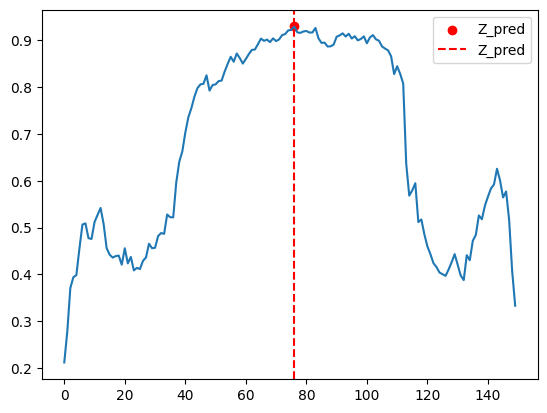

In [56]:
plt.plot( check_y_pred)
plt.scatter(z_pred, check_y_pred[z_pred], c='r', label='Z_pred')
plt.axvline(x=z_pred, color='red', linestyle='--', label='Z_pred')

plt.legend()
plt.show()

In [47]:
df.sample(3)

,tomo_id,Unnamed: 0,row_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors,motor_place
275,tomo_6acb9e,482,316,80.0,562.0,831.0,300,960,928,13.1,1,8
242,tomo_60ddbd,472,279,69.0,450.0,492.0,300,960,928,13.1,1,7
124,tomo_30b580,299,147,142.0,392.0,575.0,300,928,928,13.1,1,15
